In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
np.random.seed(0)
SAMPLES = 100
NOISE = 5
COEF = np.array([5, 0.5, -2, 1.5, 3, -1, -2])*10  #b0, b1, b2, b3
MEAN = np.array([0, 4, 0, -3, 0, 10])
K = np.arange(0, 200, 0.1)

In [3]:
# Generate a random covariance matrix
#https://stats.stackexchange.com/questions/215497/how-to-create-an-arbitrary-covariance-matrix
SIGMAS = np.array([1, 1, 2, 1, 0.1, 5]) * 1000
# producing orthonormalised q
p = (np.random.normal(size=36) * 10).reshape(6, 6)
p, _ = np.linalg.qr(p)
COV = np.matmul(np.matmul(p.T, np.diag(SIGMAS)), p)

In [4]:
COV

array([[  598.54260308,  -445.94411108,   296.26517651,    50.44138219,
          166.38770216,   206.11931946],
       [ -445.94411108,  1110.2041925 ,  -510.59518701,   978.53190778,
         -165.94340854,   156.68549854],
       [  296.26517651,  -510.59518701,  2275.57115592, -1803.84289531,
          -24.26120466,  -459.36923312],
       [   50.44138219,   978.53190778, -1803.84289531,  3119.29617696,
           17.88168003,   466.13335859],
       [  166.38770216,  -165.94340854,   -24.26120466,    17.88168003,
         1590.25115198,   435.53681826],
       [  206.11931946,   156.68549854,  -459.36923312,   466.13335859,
          435.53681826,  1406.13471954]])

### Generate multidimensional data with high correlation between two of the features

In [5]:
def generate_dataset(correlated = True):
    # Create a sample with three independent variables, two of them highly correlated
    # The first column in X corresponds to the intercept coefficient
    X = np.random.multivariate_normal(MEAN, COV, SAMPLES)
    #if correlated:
    #    X = np.hstack((X, X[:, 1][:, np.newaxis] + NOISE * np.random.randn(SAMPLES, 1)))    
    #else:
    #    X = np.hstack((X, np.random.rand(SAMPLES, 1)))
    X = np.hstack((np.ones((SAMPLES, 1)), X))
    # Calculating the value of the dependent variable before adding noise
    y = np.matmul(X, COEF)
    # Adding some normal random noise
    #X[:, 1:] = X[:, 1:] + NOISE * np.random.randn(SAMPLES, len(COEF) - 1)
    y = y + NOISE * np.random.randn(SAMPLES)
    
    return (X, y)
(X, y) = generate_dataset()

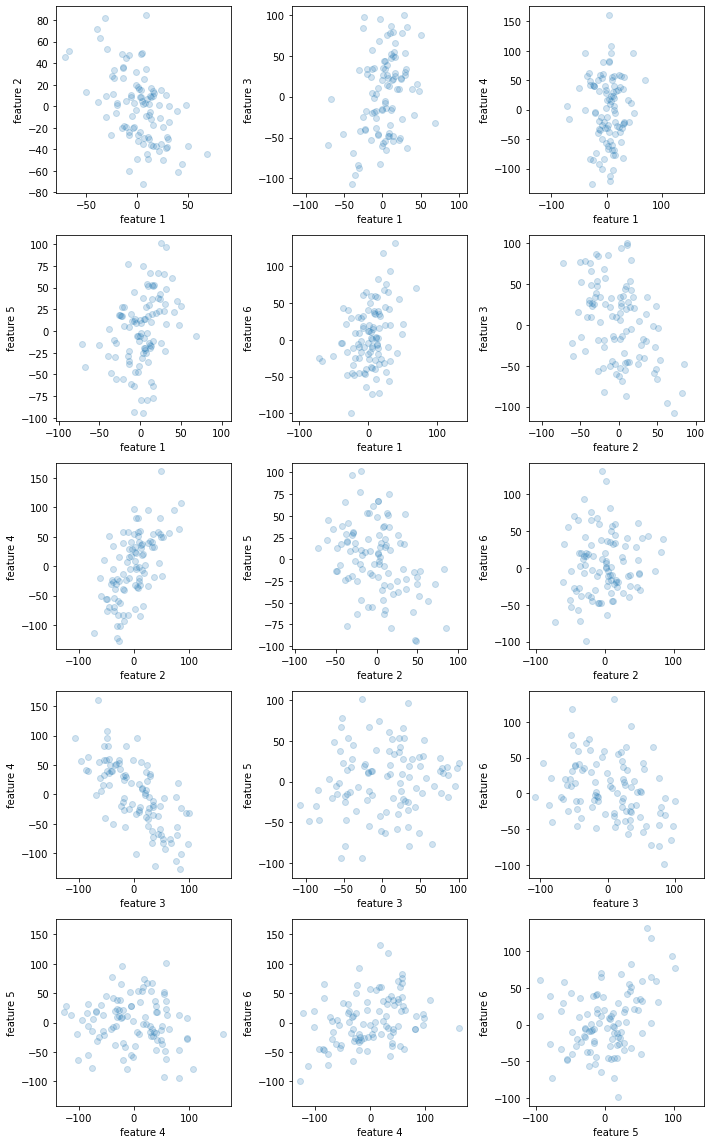

In [6]:
comb = list(combinations(range(1, X.shape[1]), 2))
c = 3
r = len(comb) // 3
_, ax = plt.subplots(r, c, figsize = (10, 16))
for i, ind in enumerate(comb):
    r = i // 3
    c = i % 3
    ax[r, c].scatter(X[:, ind[0]], X[:, ind[1]], alpha = 0.2)
    ax[r, c].set_xlabel('feature ' + str(ind[0]))
    ax[r, c].set_ylabel('feature ' + str(ind[1]))
    ylim = ax[r, c].get_ylim()
    xlim = ax[r, c].get_xlim()
    min_lim = min(min(ylim), min(xlim))
    max_lim = max(max(ylim), max(xlim))
    ax[r, c].set_xlim(min_lim, max_lim)
    ax[r, c].set_ylim(min_lim, max_lim)
    #ax[r, c].set_aspect('equal', 'box')
plt.tight_layout()

In [7]:
# Show the effect of colinearity on least squares
def test_impact_colinearity(correlated=True):
    print('Actual coefficients = ' + str(COEF))
    res = []
    for i in range(10):
        (X, y) = generate_dataset(correlated=correlated)
        res.append(np.dot(y, np.dot(X, np.linalg.inv(np.dot(X.T, X)))))
        rmse = np.power(np.sum(np.power(y - np.dot(np.array(res[-1]), X.T), 2)), 0.5) / X.shape[0]
        print("coef = " + str(res[-1]) + ", RMSE = " + str(rmse))
    print('Coef. standard deviation: '+ str(np.std(np.array(res), axis = 0)))

In [8]:
test_impact_colinearity(correlated=True)

Actual coefficients = [ 50.   5. -20.  15.  30. -10. -20.]
coef = [ 50.15456241   4.98306416 -20.00280904  14.98612966  30.01229834
 -10.00716178 -20.02214692], RMSE = 0.5078012443276345
coef = [ 50.42711481   5.07440909 -19.96195697  14.94960574  29.9669933
 -10.0036742  -20.00984099], RMSE = 0.4981130572825984
coef = [ 49.83565031   4.97497425 -20.02557773  15.01585156  30.00986946
 -10.00434055 -20.00776766], RMSE = 0.4429214835565706
coef = [ 50.38305062   5.01873007 -19.99129909  14.97948536  29.97291766
  -9.99354628 -19.98959739], RMSE = 0.52617975085059
coef = [ 49.66595908   4.99894104 -19.98758778  14.99857485  29.9980041
 -10.00399155 -20.0057122 ], RMSE = 0.47429647111373263
coef = [ 50.22760965   5.0137678  -19.96906794  14.99940995  29.98671894
  -9.99635738 -20.00357421], RMSE = 0.4906813775808013
coef = [ 49.83733989   5.0246243  -19.9871816   14.99879003  29.98820983
  -9.99120337 -20.0033322 ], RMSE = 0.46248974575657603
coef = [ 49.84658598   5.02595946 -20.00638542 

In [9]:
# Are we sure that this is not noise effect?
# Yes, the variability of the highly correlated dependent variables is an 
# order of magnitude higher than those that are not correlated (see cell above)
# The bias increases, the variance decreases :)
test_impact_colinearity(correlated=False)

Actual coefficients = [ 50.   5. -20.  15.  30. -10. -20.]
coef = [ 49.52324      5.03169448 -19.97484506  14.99479645  29.998393
  -9.98939617 -20.01116982], RMSE = 0.4839031606965433
coef = [ 49.7686414    5.06485533 -19.98804817  14.98008759  29.99556568
 -10.00703792 -20.01797651], RMSE = 0.5294582368107374
coef = [ 49.51994219   5.062747   -19.95890199  14.97973333  29.97249479
 -10.0021192  -20.02874834], RMSE = 0.48705747139664246
coef = [ 50.14729721   5.01462923 -19.98727302  14.99108067  29.9854642
  -9.98374325 -20.0086431 ], RMSE = 0.48880409701391614
coef = [ 50.1549797    5.01987117 -20.00251431  14.97265426  29.97158718
  -9.99607861 -20.013539  ], RMSE = 0.49017414794832814
coef = [ 50.56888433   4.98466177 -20.04957803  15.01759655  30.02420515
  -9.99225696 -19.99739289], RMSE = 0.4471104147128535
coef = [ 49.97609418   4.96242729 -20.01475273  15.00381464  30.00663758
 -10.00979775 -19.98189789], RMSE = 0.4728728527801727
coef = [ 50.1636203    5.04059453 -19.9805570

In [10]:
# Ridge regression implementation
def ridge_regression(k, X, y):
    # Standardising the independent variables
    X_s = np.copy(X)
    X_s[:, 1:] = (X_s[:, 1:] - np.mean(X_s[:, 1:], axis=0)) / np.std(X_s[:, 1:])
    
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X_s.T, X_s) + k * np.identity(X_s.shape[1])), X_s.T), y)

In [11]:
def data_folds(X, k = 10):
    fold_size = int(len(X) / k)
    partitions = list(range(len(X)))
    random.shuffle(partitions)
    return np.array(partitions)[0:k * fold_size].reshape(k, fold_size)

In [12]:
# My initial mistake with the ridge plotwas to use a too small value of K. That's why in some cases the coefficients didn't seem to converge to zero
# Another error is that the independent variables have to be standardised

Text(0, 0.5, 'normalised coefficients')

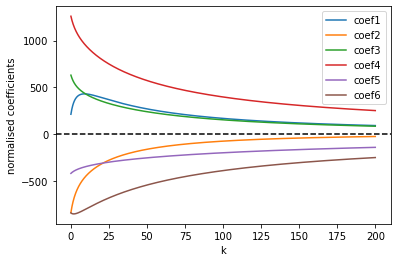

In [13]:
# Selecting k with a ridge trace
columns = []
for i in range(len(COEF)):
    columns.append('coef' + str(i))
trace = pd.DataFrame(index = K, columns = columns)
for k in K:
    trace.loc[k] = ridge_regression(k, X, y)

fig, ax = plt.subplots()
for i in range(1, X.shape[1]):
    ax.plot(trace['coef' + str(i)])
plt.axhline(y=0, color='k', linestyle='--')
ax.legend(trace.columns[1:])
#ax.axvline(x = 1000, color = 'r', linestyle = '--')
ax.set_xlabel('k')
ax.set_ylabel('normalised coefficients')

In [14]:
# Selecting k with close validation
folds = data_folds(X)
rmse_train_mean = []
rmse_train_std = []
rmse_test_mean = []
rmse_test_std = []
for k in K:
    rmse_train = []
    rmse_test = []
    for i in range(folds.shape[0]):
        x_test = X[folds[i, :], :]
        y_test = y[folds[i, :]]
        indexes = folds[[j for j in range(folds.shape[0]) if j!=i], :].flatten()
        x_train = X[indexes, :]
        y_train = y[indexes]
        
        coef = ridge_regression(k, x_train, y_train)
        x_train_s = np.copy(x_train)
        x_train_s[:, 1:] = (x_train_s[:, 1:] - np.mean(x_train_s[:, 1:], axis=0)) / np.std(x_train_s[:, 1:])
        x_test_s = np.copy(x_test)
        x_test_s[:, 1:] = (x_test_s[:, 1:] - np.mean(x_test_s[:, 1:], axis=0)) / np.std(x_test_s[:, 1:])
        
        rmse_train.append(np.power(np.sum(np.power(y_train - np.dot(np.array(coef), x_train_s.T), 2)), 0.5) / x_train_s.shape[0])
        rmse_test.append(np.power(np.sum(np.power(y_test - np.dot(np.array(coef), x_test_s.T), 2)), 0.5) / x_test_s.shape[0])
    rmse_train_mean.append(np.mean(rmse_train))
    rmse_train_std.append(np.std(rmse_train))
    rmse_test_mean.append(np.mean(rmse_test))
    rmse_test_std.append(np.std(rmse_test))
    
rmse_train_mean = np.array(rmse_train_mean)
rmse_train_std = np.array(rmse_train_std)
rmse_test_mean = np.array(rmse_test_mean)
rmse_test_std = np.array(rmse_test_std)

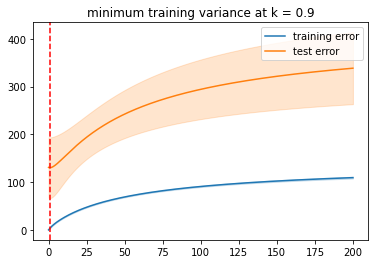

In [15]:
# Using the value of K that minimises variability for the training data
# Multiplying training variance times 100 to make it more visible
fig, ax = plt.subplots()
ax.plot(K, rmse_train_mean, color = 'C0')
ax.plot(K, rmse_test_mean, color = 'C1')
ax.fill_between(K, rmse_train_mean - rmse_train_std, rmse_train_mean + rmse_train_std, color = 'C0', alpha = 0.2)
ax.fill_between(K, rmse_test_mean - rmse_test_std, rmse_test_mean + rmse_test_std, color = 'C1', alpha = 0.2)
min_error = K[np.argmin(rmse_test_mean)]
ax.axvline(x = min_error, color = 'r', linestyle = '--')
ax.set_title('minimum training variance at k = ' + str(min_error))
ax.legend(['training error', 'test error'])

In [16]:
# TODO: refactor rmse outside of the functiosn. The same to the one to standardise the data